# Statistique en Grande Dimension et Apprentissage - TP 1


Ce TP est consacré aux k-plus proches voisins. A travers la mise en oeuvre de cet algorithme, les objectifs sont de se familiariser avec le calcul empirique du risque, la validation simple, la validation croisée ainsi que le choix de paramètres (ou hyper paramètres). On abordera aussi la notion de surapprentissage.



## Exercice 1

### 1. 

In [1]:
def Echantillon(n):
    
    X1 = np.random.uniform(0,1,n)
    X2 = np.random.uniform(0,1,n)
    V = X1 + 2*X2
    Y = np.zeros(n)
    
    Y[V <= 1] = [int(alpha >= np.random.uniform(0,1,1)[0]) for i in range(np.sum(V <= 1))]
    Y[V > 1] = [int(beta >= np.random.uniform(0,1,1)[0]) for i in range(np.sum(V > 1))]
    
    return pd.DataFrame({'X1': X1,'X2': X2,'Y': Y.astype(int)})

### 2.

In [2]:
from random import *
import numpy as np
import pandas as pd


pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)


n = 1000
max_Voisins = 100

alpha = 0.9
beta = 0.1

df_train = Echantillon(n)
df_test = Echantillon(n)

### 3.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
plt.figure(figsize=(8,8))
sns.scatterplot(x="X1", y="X2", hue="Y", style = "Y", data=df_train, s =100)

In [4]:
Xtrain,Ytrain = df_train[["X1","X2"]], df_train["Y"]
Xtest,Ytest = df_test[["X1","X2"]], df_test["Y"]

In [5]:
from sklearn.neighbors import KNeighborsClassifier


Poids = ["uniform", "distance"]
p = Poids[0]

k = 1

knn = KNeighborsClassifier(n_neighbors=k, weights = p)
knn.fit(Xtrain, Ytrain) 

print(knn.predict([[0.5, 0.5]])," avec une probabilité de ", knn.predict_proba([[0.5, 0.5]]))
print(knn.predict([[1/4, 3/4]])," avec une probabilité de ", knn.predict_proba([[1/4, 3/4]]))

[0]  avec une probabilité de  [[1. 0.]]
[0]  avec une probabilité de  [[1. 0.]]


### 5.


In [6]:
# Pour k = 1 :
knn = KNeighborsClassifier(n_neighbors=1, weights = p)
knn.fit(Xtrain, Ytrain)
k1 = knn.predict(Xtest)

# pour k = 20 :
knn = KNeighborsClassifier(n_neighbors=20, weights = p)
knn.fit(Xtrain, Ytrain)
k20 = knn.predict(Xtest)

#pd.DataFrame({"knn[K=1]": k1, "knn[K=20]": k20})

### 6. 

In [7]:
from sklearn.metrics import confusion_matrix

print("matrice de confusion avec k=1")
M1 = confusion_matrix(Ytest, k1)
M1

matrice de confusion avec k=1


array([[610,  95],
       [ 87, 208]])

In [8]:
print("matrice de confusion avec k=20")
M20 = confusion_matrix(Ytest, k20)
M20

matrice de confusion avec k=20


array([[679,  26],
       [ 80, 215]])

### 7.

In [9]:
print("Précision de classification avec k=1:", M1.trace()/M1.sum())
print("Précision de classification avec k=20:", M20.trace()/M20.sum())

Précision de classification avec k=1: 0.818
Précision de classification avec k=20: 0.894


### 8.

In [10]:
Voisins = np.arange(1,max_Voisins)
Precision_Uniform = []
Precision_Distance = []

for i in Voisins:
    knn = KNeighborsClassifier(n_neighbors=i, weights = "uniform")
    knn.fit(Xtrain, Ytrain)
    M = confusion_matrix(Ytest, knn.predict(Xtest))
    Precision_Uniform.append(M.trace()/M.sum())
    
for i in Voisins:
    knn = KNeighborsClassifier(n_neighbors=i, weights = "distance")
    knn.fit(Xtrain, Ytrain)
    M = confusion_matrix(Ytest, knn.predict(Xtest))
    Precision_Distance.append(M.trace()/M.sum())
    
df_Erreur_1 = pd.DataFrame({"Voisins": Voisins, 
                          "Précision": Precision_Uniform,
                          "Poids": "Uniforme"})

df_Erreur_2 = pd.DataFrame({"Voisins": Voisins, 
                          "Précision": Precision_Distance,
                          "Poids": "Distance"})
df_Erreur = pd.concat([df_Erreur_1, df_Erreur_2])

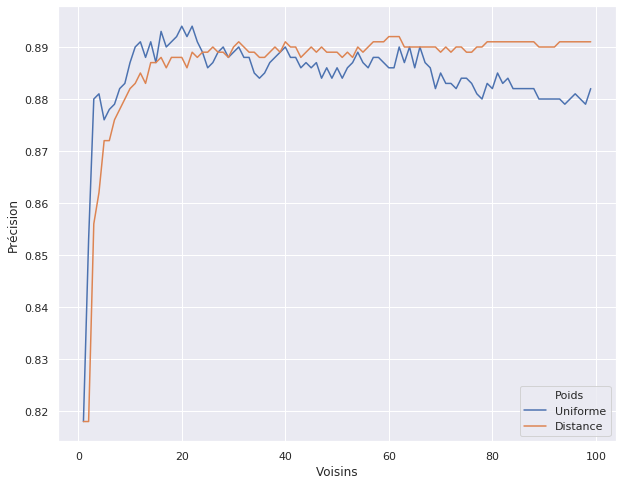

In [11]:
sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.lineplot(x="Voisins", y="Précision", hue="Poids", data=df_Erreur)

### 9.

##### a. validation croisée de type Leave-One-Out

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

#on regroupe les données pour la validation croisée
df = pd.concat([df_train,df_test], ignore_index=True)
X, Y = df[["X1","X2"]], df["Y"]

loo = LeaveOneOut()
knn_cv = KNeighborsClassifier(n_neighbors=11, weights = p)
cv_scores = cross_val_score(knn_cv, X, Y, cv=loo)

print(cv_scores)
print("moyenne des scores:", np.mean(cv_scores))

[1. 1. 0. ... 1. 1. 1.]
moyenne des scores: 0.8905


##### b. programmant d'une validation croisée  avec 5-fold

In [13]:
cv = 5
Voisins = np.arange(1,max_Voisins)

I=np.arange(df.shape[0])
taillefold = int(df.shape[0]/cv)

Cross_V = {}


for k in Voisins:  
    Precision = []

    for i in range(cv):
        
        Iv = I[i*taillefold: (i+1)*taillefold]
        
        Xtr=X.drop(Iv, axis=0)
        Ytr=Y.drop(Iv, axis=0)

        Xte=X.iloc[Iv]
        Yte=Y.iloc[Iv]
    
        knn = KNeighborsClassifier(n_neighbors=k, weights = p)
        knn.fit(Xtr, Ytr)
        M = confusion_matrix(Yte, knn.predict(Xte))
        Precision.append(M.trace()/M.sum())

    Cross_V [k] = round((np.array(Precision)).mean(), 4) 

In [14]:
print("k:" ,max(zip(Cross_V.values(), Cross_V.keys()))[1])
print("précision:" ,max(zip(Cross_V.values(), Cross_V.keys()))[0])

k: 54
précision: 0.891


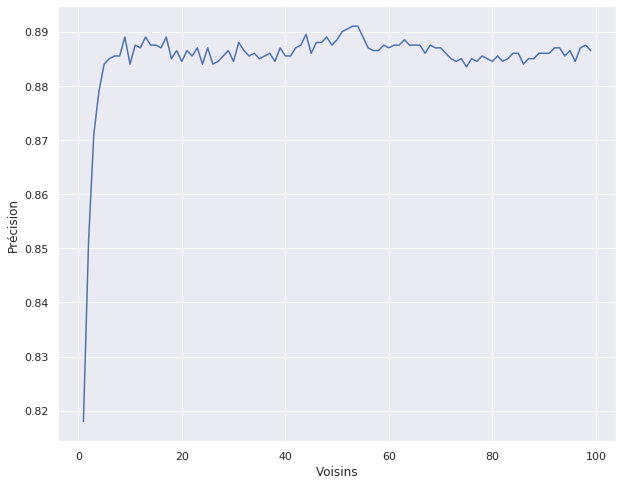

In [15]:
df_CV = pd.DataFrame({'Voisins'   : list(Cross_V.keys()),
                      'Précision' : list(Cross_V.values())})
sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.lineplot(x="Voisins", y="Précision", data=df_CV)

In [16]:
from sklearn.model_selection import GridSearchCV

#on crée un nouveau modèle knn2
knn2 = KNeighborsClassifier()

#on crée un dictionnaire de toutes les valeurs que nous voulons tester avec n_neighbors
param_grid = {"n_neighbors": np.arange(1, max_Voisins), "weights" : ["uniform", "distance"]}

#on utilise gridsearch pour tester toutes les valeurs de n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

#ajustement du modèle aux données
knn_gscv.fit(X, Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                         'weights': ['uniform', 'distance']},
             pre_dispat

In [17]:
#la valeur de n_neighbors la plus performante:
knn_gscv.best_params_

{'n_neighbors': 39, 'weights': 'distance'}

In [18]:
#le score moyen pour la valeur la plus performante de n_neighbors
knn_gscv.best_score_

0.892

# Exercice 2

### 1. 

In [19]:
path_Home = "/home/malick/Bureau/Data/Donnees_knn"
path = "/users/mmath/wade/Bureau/Data/Statistique_en_grande_dimension/Donnees_knn"

df_train = pd.read_csv(path + "/synth_train.txt",  sep='\t')
df_test = pd.read_csv(path + "/synth_test.txt",  sep='\t')

In [20]:
df_train.head()

,y,x1,x2
0,2,-0.722211,2.004471
1,2,-0.924679,0.483669
2,2,-0.766023,0.794329
3,2,-0.073289,0.969929
4,1,-1.392912,0.999697


<Figure size 720x576 with 0 Axes>

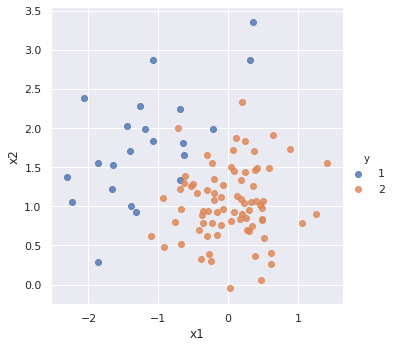

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.lmplot(data=df_train, x='x1', y='x2', hue='y', markers=['o', 'o'], fit_reg=False)

### 2. 

In [22]:
k = 30

Xtrain,Ytrain = df_train[["x1","x2"]], df_train["y"]
Xtest,Ytest = df_test[["x1","x2"]], df_test["y"]

##### 2.5 

In [23]:
knn = KNeighborsClassifier(n_neighbors=k, weights = p)
knn.fit(Xtrain, Ytrain)
k30 = knn.predict(Xtest)

#pd.DataFrame({"knn[K=30]": k30})

##### 2.6

In [24]:
print("matrice de confusion avec k=30")
M30 = confusion_matrix(Ytest, k30)
M30

matrice de confusion avec k=30


array([[ 31,  31],
       [  0, 138]])

##### 2.7

In [25]:
print("Précision de classification avec k=30:", M30.trace()/M30.sum())


Précision de classification avec k=30: 0.845


##### 2.9

###### a. validation croisée de type Leave-One-Out

In [26]:
#on regroupe les données pour la validation croisée
df = pd.concat([df_train,df_test], ignore_index=True)
X, Y = df[["x1","x2"]], df["y"]

loo = LeaveOneOut()
knn_cv = KNeighborsClassifier(n_neighbors=k, weights = p)
cv_scores = cross_val_score(knn_cv, X, Y, cv=loo)

print(cv_scores)
print("moyenne des scores:", np.mean(cv_scores))

[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
moyenne des scores: 0.9366666666666666


##### b. programmant d'une validation croisée  avec 5-fold

In [27]:
cv = 5
max_Voisins = 50

Voisins = np.arange(1,max_Voisins)

I=np.arange(df.shape[0])
taillefold = int(df.shape[0]/cv)

Cross_V = {}


for k in Voisins:  
    Precision = []

    for i in range(cv):
        
        Iv = I[i*taillefold: (i+1)*taillefold]
        
        Xtr=X.drop(Iv, axis=0)
        Ytr=Y.drop(Iv, axis=0)

        Xte=X.iloc[Iv]
        Yte=Y.iloc[Iv]
    
        knn = KNeighborsClassifier(n_neighbors=k, weights = p)
        knn.fit(Xtr, Ytr)
        M = confusion_matrix(Yte, knn.predict(Xte))
        Precision.append(M.trace()/M.sum())

    Cross_V [k] = round((np.array(Precision)).mean(), 4) 

In [28]:
print("k:" ,max(zip(Cross_V.values(), Cross_V.keys()))[1])
print("précision:" ,max(zip(Cross_V.values(), Cross_V.keys()))[0])

k: 30
précision: 0.95


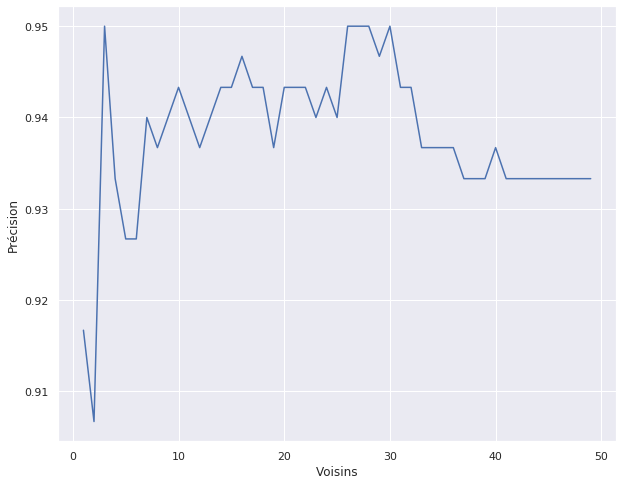

In [29]:
df_CV = pd.DataFrame({'Voisins'   : list(Cross_V.keys()),
                      'Précision' : list(Cross_V.values())})
sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.lineplot(x="Voisins", y="Précision", data=df_CV)

In [30]:
from sklearn.model_selection import GridSearchCV

#on crée un nouveau modèle knn2
knn2 = KNeighborsClassifier()

#on crée un dictionnaire de toutes les valeurs que nous voulons tester avec n_neighbors
param_grid = {"n_neighbors": np.arange(1, max_Voisins), "weights" : ["uniform", "distance"]}

#on utilise gridsearch pour tester toutes les valeurs de n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

#ajustement du modèle aux données
knn_gscv.fit(X, Y)

/app/anaconda/3-2019-07/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [31]:
#la valeur de n_neighbors la plus performante:
knn_gscv.best_params_

{'n_neighbors': 3, 'weights': 'uniform'}

In [32]:
#le score moyen pour la valeur la plus performante de n_neighbors
knn_gscv.best_score_

0.95

#### 3.

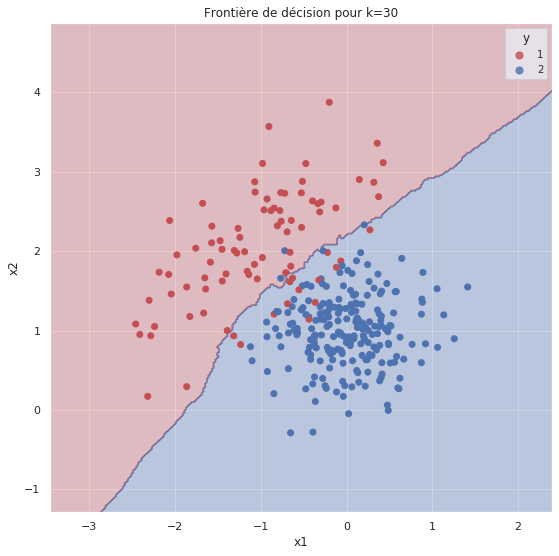

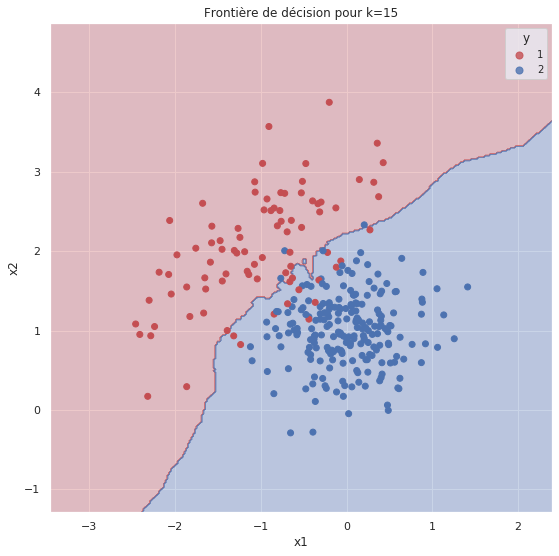

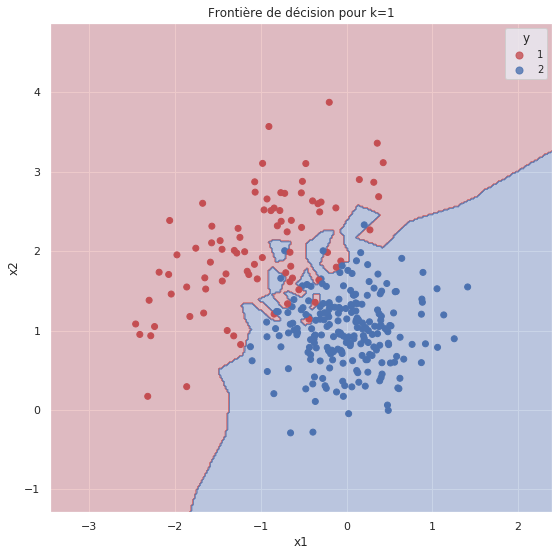

In [33]:
from matplotlib.colors import ListedColormap

cmapColor = ListedColormap(['r', 'b'])

# Method to create a mesh of points
def makeMeshgrid(x, y, h=0.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    # Meshgrid ndarrays
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    return xx, yy

# Defining the data to use in meshgrid calculation. Outputting xx and yy ndarrays
X0, X1 = X['x1'], X['x2']
xx, yy = makeMeshgrid(X0, X1)

for k in [30, 15, 1]:

    # Training the model per the optimum k value
    model = KNeighborsClassifier(n_neighbors=k, weights = p)
    model.fit(X, Y)

    # Calculating the decision boundaries
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(9,9))


    # Plotting the decision boundaries
    plt.contourf(xx, yy, Z, alpha = 0.3, cmap=cmapColor)

    # Scatter plot Sepal width/length
    colorSet = {1:'r', 2:'b'}

    plt.scatter(X0, X1,  marker='o', c=[colorSet[i] for i in df['y']], label=None)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Title
    plt.title('Frontière de décision pour k=%.f'%(k))

    # Legend
    for name, color in zip(["1","2"], ['r', 'b']):
            plt.scatter([], [], alpha=0.8, s=50, c=color, label=name)   

    pst = plt.legend(loc='best', scatterpoints=1, frameon=True, fontsize='10',labelspacing=0.5, title='y')

# Exercice 3

### 1.

In [34]:
path_Home = "/home/malick/Bureau/Data/Donnees_knn"
path = "/users/mmath/wade/Bureau/Data/Statistique_en_grande_dimension/Donnees_knn"

df_train = pd.read_csv(path + "/mnist_train.csv",  sep=',')
df_test = pd.read_csv(path + "/mnist_test.csv",  sep=',')

### 2.

In [35]:
Xtrain = df_train.iloc[:,1:df_train.shape[1]]
Ytrain = df_train.iloc[:,0:1]

Xtest = df_test.iloc[:,1:df_train.shape[1]]
Ytest = df_test.iloc[:,0:1]

### 3.

### 4. 

### 5.

In [36]:
import time

Xtrain_10 = Xtrain.iloc[0:10]
Ytrain_10 = Ytrain.iloc[0:10]

k = 5

t1 = time.time()

knn = KNeighborsClassifier(n_neighbors=k, weights = p)
knn.fit(Xtrain_10, Ytrain_10)

t2 = time.time()
t =t2 -t1


/app/anaconda/3-2019-07/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


### 6.

In [37]:
Xtrain_12000 = Xtrain.sample(n=12000, random_state=1, replace=False)
Ytrain_12000 = Ytrain.sample(n=12000, random_state=1, replace=False)

Xtest_500 = Xtest.sample(n=500, random_state=1, replace=False)
Ytest_500 = Ytest.sample(n=500, random_state=1, replace=False)

### 7.

In [38]:
k = 10

knn = KNeighborsClassifier(n_neighbors=k, weights = p)
knn.fit(Xtrain_12000, Ytrain_12000)

predict = knn.predict(Xtest_500)

/app/anaconda/3-2019-07/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


### 8.

In [39]:
print("matrice de confusion")
M = confusion_matrix(Ytest_500, predict)
M

matrice de confusion


array([[61,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 48,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  1, 41,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0, 55,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0, 55,  0,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  1, 42,  1,  0,  0,  1],
       [ 1,  0,  0,  0,  0,  0, 44,  0,  0,  0],
       [ 0,  5,  1,  0,  0,  0,  0, 46,  0,  2],
       [ 0,  0,  1,  1,  0,  1,  0,  0, 45,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  2,  0, 38]])

In [40]:
print("Précision de classification:", M.trace()/M.sum())

Précision de classification: 0.95


###### 9. Meilleur algorithme avec sklearn.model_selection.GridSearchCV

In [41]:
from sklearn.model_selection import GridSearchCV

#on crée un nouveau modèle knn
knn = KNeighborsClassifier()

#on crée un dictionnaire de toutes les valeurs que nous voulons tester avec n_neighbors
param_grid = {"n_neighbors": np.arange(1, 30), "weights" : ["uniform", "distance"]}

#on utilise gridsearch pour tester toutes les valeurs de n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)

#ajustement du modèle aux données
knn_gscv.fit(Xtrain_12000 , Ytrain_12000 )

/app/anaconda/3-2019-07/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


KeyboardInterrupt: 

In [ ]:
#la valeur de n_neighbors la plus performante:
knn_gscv.best_params_

In [ ]:
#le score moyen pour la valeur la plus performante de n_neighbors
knn_gscv.best_score_

### Exercice 3 / TD

In [48]:
#classe pour standardisation(On centre et réduis nos valeurs)
from sklearn.preprocessing import StandardScaler


#instanciation
sc = StandardScaler()

#transformation – centrage-réduction
Xtrain_12000_centree = sc.fit_transform(Xtrain_12000)

In [55]:
#classe pour l'ACP
from sklearn.decomposition import PCA

#instanciation
acp = PCA(n_components=2)

#calculs
Xtrain_12000_ACP = acp.fit_transform(Xtrain_12000)

#nombre de composantes calculées
print(acp.n_components_)

2


In [56]:
#proportions de variance associées aux axes
acp.explained_variance_ratio_

array([0.0952412 , 0.07159431])

In [60]:
df1 = pd.DataFrame(Xtrain_12000_ACP, columns=['X1','X2'])
df2 = pd.DataFrame(Xtrain_12000_ACP, columns=['X1','X2'])

df_ACP = pd.concat([dataframe,Ytrain_12000], axis=1)
df_ACP.head()

,X1,X2,5
0,160.426946,509.297235,NaN
1,831.274933,638.723694,NaN
2,-404.280252,-281.300416,NaN
3,226.269933,-372.968146,NaN
4,-727.529357,138.553950,NaN


In [61]:
Ytrain_12000

,5
6419,3
19262,3
50776,4
12637,5
13397,1
17851,6
20654,2
35453,2
49613,2
45992,2
